# Python

## 1. Python import and define functions

*** 
###  

In [1]:
# Python import
import os
import argparse
import collections
import random
import copy
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import  sklearn.preprocessing as preprocessing
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,  Model, backend
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tfdeterminism import patch

In [2]:
# Architecture of deep learning model
class CNN_Structure_Property(Model):
    def __init__(self, filter_num, units):
        super().__init__()
        self.conv1_seq =  layers.Conv1D(filters = filter_num,kernel_size = 12,strides = 1,padding = "valid",input_shape = (9000,4),activation = "relu")
        
        self.conv2_seq =  layers.Conv1D(filters = int(filter_num/2),kernel_size = 6,strides = 1,padding = "valid",activation = "relu")
        self.drop1 = layers.Dropout(0.3)
        
        self.pooling_seq = layers.MaxPooling1D(pool_size =4, strides =4)
        self.drop2 = layers.Dropout(0.3)
        
        self.dense1 = layers.Dense(units = 128, activation = "sigmoid")
        
        self.flatten_seq = layers.Flatten()
        self.flatten_structure_property = layers.Flatten()
        
        self.dense2 = layers.Dense(units = units, activation = "relu")
        self.drop3 = layers.Dropout(0.3)
        self.dense3 = layers.Dense(units = 2, activation = "softmax")
        
    def call(self,inputs):
        seq = self.flatten_seq(self.drop2(self.pooling_seq(self.drop1(self.conv2_seq(self.conv1_seq(inputs[0]))))))
        structure_property = self.flatten_structure_property(self.dense1(inputs[1]))
        
        x = layers.concatenate([seq, structure_property],axis=-1)
        x = self.dense2(x)
        x = self.drop3(x)
        y = self.dense3(x)
        return y

In [3]:
# Whether in jupyter notebook
def isnotebook() -> bool:
    """
    Returns True if the current execution environment is a jupyter notebook
    https://stackoverflow.com/questions/15411967/how-can-i-check-if-code-is-executed-in-the-ipython-notebook
    """
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

In [4]:
#get filepath of input and output
def get_filepath():
    parser = argparse.ArgumentParser()
    parser.add_argument("--training",dest = "training", help = "TrainingSet file")
    parser.add_argument("--test",dest = "test",default = 20,help = "TestSet file")
    parser.add_argument("-O","-o","--outputdir",dest = "outputdir",help = "Output dir of models")
    args = parser.parse_args()
    return args

In [5]:
# padding sequence to 9000nt
def padding_truncate_seq(seq):
    length = len(seq)  
    if length > 9000: 
        seq = seq[:9000]   # trancate seq to 9000nt
    else:
        seq = seq + (9000 -length)*'N'  #padding N after seq to 9000nt
    return seq

In [6]:
# Convert data to tensor
def convert2tensor(data):
    NT_dict = {'A':np.array([1,0,0,0]),'T':np.array([0,1,0,0]),'G':np.array([0,0,1,0]),'C':np.array([0,0,0,1]),'N':np.array([0,0,0,0])}
    label_dict = {'0': 0, '1':1}
    
    seq = tf.convert_to_tensor(data["cdna"].apply(lambda x:np.array([ NT_dict[i] for i in x],dtype=np.float32)))
    structure = tf.convert_to_tensor(np.array(data.iloc[:,1:15]),dtype=np.float32)
    rna_property = tf.convert_to_tensor(np.array(data.iloc[:,15:-1]),dtype=np.float32)
    structure_property = tf.concat([structure,rna_property], -1)
    label = tf.convert_to_tensor(data["tag"].apply(lambda x:np.array(label_dict[str(x)],dtype=np.float32)))
    
    X = [seq, structure_property]
    y = label
    return X,y

In [7]:
#Evaluate performance of model
def evaluate_performance(y_test, y_pred, y_prob):
    # AUROC
    auroc = metrics.roc_auc_score(y_test,y_prob)
    auroc_curve = metrics.roc_curve(y_test, y_prob)
    # AUPRC
    auprc=metrics.average_precision_score(y_test, y_prob) 
    auprc_curve=metrics.precision_recall_curve(y_test, y_prob)
    #Accuracy
    accuracy=metrics.accuracy_score(y_test,y_pred) 
    #MCC
    mcc=metrics.matthews_corrcoef(y_test,y_pred)
    
    recall=metrics.recall_score(y_test, y_pred)
    precision=metrics.precision_score(y_test, y_pred)
    f1=metrics.f1_score(y_test, y_pred)
    class_report=metrics.classification_report(y_test, y_pred,target_names = ["control","case"])

    model_perf = {"auroc":auroc,"auroc_curve":auroc_curve,
                  "auprc":auprc,"auprc_curve":auprc_curve,
                  "accuracy":accuracy, "mcc": mcc,
                  "recall":recall,"precision":precision,"f1":f1,
                  "class_report":class_report}
        
    return model_perf

In [8]:
# Output result of evaluation
def eval_output(model_perf,path):
    with open(os.path.join(path,"Evaluate_Result_TestSet.txt"),'w') as f:
        f.write("AUROC=%s\tAUPRC=%s\tAccuracy=%s\tMCC=%s\tRecall=%s\tPrecision=%s\tf1_score=%s\n" %
               (model_perf["auroc"],model_perf["auprc"],model_perf["accuracy"],model_perf["mcc"],model_perf["recall"],model_perf["precision"],model_perf["f1"]))
        f.write("\n######NOTE#######\n")
        f.write("#According to help_documentation of sklearn.metrics.classification_report:in binary classification, recall of the positive class is also known as sensitivity; recall of the negative class is specificity#\n\n")
        f.write(model_perf["class_report"])

In [9]:
# Plot AUROC of model
def plot_AUROC(model_perf,path):
    #get AUROC,FPR,TPR and threshold
    roc_auc = model_perf["auroc"]
    fpr,tpr,threshold = model_perf["auroc_curve"]
    #return AUROC info
    temp_df = pd.DataFrame({"FPR":fpr,"TPR":tpr})
    temp_df.to_csv(os.path.join(path,"AUROC_info.txt"),header = True,index = False, sep = '\t')
    #plot
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='AUROC (area = %0.2f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("AUROC of Models")
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(path,"AUROC_TestSet.pdf"),format = "pdf")

*** 
###  

## 2. Configution

In [10]:
# GPU Device
CONFIG = ConfigProto()
CONFIG.gpu_options.allow_growth = True
SESSION = InteractiveSession(config=CONFIG)
TF_DETERMINISTIC_OPS=1
# hdf5 
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# Random seed
patch()
SEED = 100
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
# Hyper-parameters
OPTIMIZER = "adam"
BATCH = 32
SHUFFLE = True
EPOCH = 100
LOSS = "sparse_categorical_crossentropy"
METRICS = ["accuracy","sparse_categorical_crossentropy"]
PATIENCE = 10
filters_num_list = [32,64,128]
units_list = [256,512,1024]

# Index of model performance
ModelPerf = collections.namedtuple('ModelPerf',
                                   ['auroc', 'auroc_curve', 'auprc', 'auprc_curve', 'accuracy', 
                                    'mcc','recall', 'precision', 'f1', 'class_report','ce_loss'])

# Output direction
output_dir = "./01_CNN_Output/CNN_9000nt_structure_frequency_Model_Output"
if not (os.path.exists(output_dir)):
    os.makedirs(output_dir)

TensorFlow version 2.0.0 has been patched using tfdeterminism version 0.3.0


*** 
###  

## 3. Data Processing

In [11]:
# Load dataset files
Training_set_sequence = pd.read_csv("/data/rnomics8/yuanguohua/RNAlight_Private/mRNA/03_Model_Construction/mRNA_sublocation_TrainingSet.tsv",sep='\t')
Training_set_structure = pd.read_csv("../../Structure_Dataset/mRNA/mRNA_sublocation_TrainingSet_structure.txt",sep='\t')
Training_set_property = pd.read_csv("../../Property_Dataset/mRNA/mRNA_sublocation_TrainingSet_biochemical.txt",sep='\t')

Test_set_sequence = pd.read_csv("/data/rnomics8/yuanguohua/RNAlight_Private/mRNA/03_Model_Construction/mRNA_sublocation_TestSet.tsv",sep='\t')
Test_set_structure = pd.read_csv("../../Structure_Dataset/mRNA/mRNA_sublocation_TestSet_structure.txt",sep='\t')
Test_set_property = pd.read_csv("../../Property_Dataset/mRNA/mRNA_sublocation_TestSet_biochemical.txt",sep='\t')

# property info
Train_df_property  = Training_set_property.iloc[:,1:]
# Z-Score using scipy
Train_df_property['length'] = stats.zscore(Train_df_property['length'])
Train_df_property['MFE'] = stats.zscore(Train_df_property['MFE'])
# property info
Test_df_property  = Test_set_property.iloc[:,1:]
# Z-Score using scipy
Train_df_property['length'] = stats.zscore(Train_df_property['length'])
Train_df_property['MFE'] = stats.zscore(Train_df_property['MFE'])

# Format :[seq] [structure] [label]
dataset_training = pd.concat([Training_set_sequence.iloc[:,2],Training_set_structure.iloc[:,2:],Train_df_property,Training_set_sequence.iloc[:,3]],axis = 1)
dataset_test = pd.concat([Test_set_sequence.iloc[:,2],Test_set_structure.iloc[:,2:],Test_df_property,Test_set_sequence.iloc[:,3]],axis = 1)

# Fix seq to 9000nt
dataset_training["cdna"] = dataset_training["cdna"].apply(lambda x:padding_truncate_seq(x))
dataset_test["cdna"] = dataset_test["cdna"].apply(lambda x:padding_truncate_seq(x))

*** 
###  

In [12]:
X_Whole_training,y_Whole_training = convert2tensor(dataset_training)

## 4. Optimize hyperparameters by five-fold cross validation

In [13]:
# This dataframe can store the highest mean of auroc among five-fold cross validations with each combination of hyperparameters
comb_auroc = pd.DataFrame(columns = ["filter_num","units","auroc_on_CV"])

# Optimize hyperparameters about model architechture
for filter_num in filters_num_list:
    for units in units_list:
        # Five-fold cross validation
        cvscore_auroc_iter = []
        kfold = KFold(n_splits=5, random_state=SEED, shuffle=True)
        for train_index, validate_index in kfold.split(dataset_training):
            # Get cross validation set
            TrainingSet_seq_structure_property = [tf.gather(X_Whole_training[0], axis=0, indices=train_index),tf.gather(X_Whole_training[1], axis=0, indices=train_index)]
            TrainingSet_label = tf.gather(y_Whole_training, axis=0, indices=train_index)
            ValidationSet_seq_structure_property = [tf.gather(X_Whole_training[0], axis=0, indices=validate_index),tf.gather(X_Whole_training[1], axis=0, indices=validate_index)]
            ValidationSet_label = tf.gather(y_Whole_training, axis=0, indices=validate_index)

            # Train model
            Net = CNN_Structure_Property(filter_num = filter_num, units = units)
            callbacks = [keras.callbacks.EarlyStopping(monitor = "val_accuracy",patience=PATIENCE, 
                                                       min_delta=1e-3,mode = "auto",restore_best_weights = True)]
            Net.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)
            Net_history = Net.fit(TrainingSet_seq_structure_property,
                                  TrainingSet_label,
                                  batch_size = BATCH,
                                  epochs = EPOCH,
                                  shuffle = SHUFFLE,
                                  callbacks = callbacks,
                                  validation_data = (ValidationSet_seq_structure_property,ValidationSet_label),
                                  verbose = 0)

            # Get the auroc of the model with maximum accuracy on validation set per fold
            cvscore_auroc_iter.append(Net_history.history["val_accuracy"][-(PATIENCE+1)])
            
        # Add to the dataframe    
        comb_auroc.loc[len(comb_auroc)] = [filter_num,units,cvscore_auroc_iter]

        
# Choose the optimal combnation of hyperparameters
comb_auroc["mean_auroc_on_CV"] = comb_auroc["auroc_on_CV"].apply(np.mean)
optimal_comb_index = comb_auroc["mean_auroc_on_CV"].argmax()
optimal_filter_num = comb_auroc["filter_num"].loc[optimal_comb_index]
optimal_units = comb_auroc["units"].loc[optimal_comb_index]

# Output result of cross validation
comb_auroc.to_csv(os.path.join(output_dir,"CNN_CV_result.tsv"),sep = '\t',header = True,index = False)

*** 
###  

## 5. Refit model with the optimal hyperparameters and whole training set

In [14]:
# Refit model
logdir = os.path.join(output_dir,"log")
Net_final = CNN_Structure_Property(filter_num = optimal_filter_num , units = optimal_units)
callbacks_final = [keras.callbacks.TensorBoard(log_dir=logdir),
                   keras.callbacks.EarlyStopping(monitor = "val_accuracy",patience=PATIENCE,restore_best_weights = True),
                   keras.callbacks.ModelCheckpoint(filepath = os.path.join(output_dir, "best_model"), monitor="val_accuracy",
                                                   save_weight_only = True, save_best_only=True,mode = "auto")]
Net_final.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)
Net_final_history = Net_final.fit(X_Whole_training,
                                  y_Whole_training,
                                  batch_size = BATCH,
                                  epochs = EPOCH,
                                  shuffle = SHUFFLE,
                                  callbacks = callbacks_final,
                                  validation_split = 0.1,
                                  verbose = 2)
Net_final.summary()

Train on 4195 samples, validate on 467 samples
Epoch 1/100
4195/4195 - 8s - loss: 0.8041 - accuracy: 0.5280 - sparse_categorical_crossentropy: 0.8041 - val_loss: 0.5890 - val_accuracy: 0.9850 - val_sparse_categorical_crossentropy: 0.5890
Epoch 2/100
4195/4195 - 4s - loss: 0.6543 - accuracy: 0.6257 - sparse_categorical_crossentropy: 0.6543 - val_loss: 0.4802 - val_accuracy: 0.8844 - val_sparse_categorical_crossentropy: 0.4802
Epoch 3/100
4195/4195 - 4s - loss: 0.6278 - accuracy: 0.6548 - sparse_categorical_crossentropy: 0.6278 - val_loss: 0.5628 - val_accuracy: 0.7109 - val_sparse_categorical_crossentropy: 0.5628
Epoch 4/100
4195/4195 - 4s - loss: 0.6095 - accuracy: 0.6706 - sparse_categorical_crossentropy: 0.6095 - val_loss: 0.6258 - val_accuracy: 0.6574 - val_sparse_categorical_crossentropy: 0.6258
Epoch 5/100
4195/4195 - 4s - loss: 0.5879 - accuracy: 0.6858 - sparse_categorical_crossentropy: 0.5879 - val_loss: 0.6308 - val_accuracy: 0.6424 - val_sparse_categorical_crossentropy: 0.630

*** 
###  

## 6. Evaluate model performance on Test set


********************** Start Model Construction ***********************


/picb/rnomics3/yuanguohua/anaconda3/envs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/picb/rnomics3/yuanguohua/anaconda3/envs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/picb/rnomics3/yuanguohua/anaconda3/envs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/picb/rnomics3/yuanguohua/anaconda3/envs/tensorflow2/lib/python3.

<Figure size 432x288 with 0 Axes>

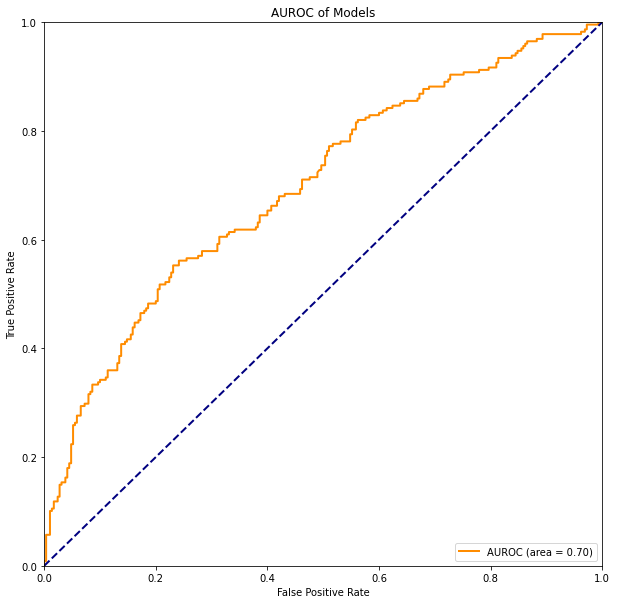

In [15]:
################################# Model Construction #############################
print("\n********************** Start Model Construction ***********************")
# Whole test set
X_test,y_test = convert2tensor(dataset_test)

# Load best model
# Load best model
best_model = CNN_Structure_Property(filter_num = optimal_filter_num , units = optimal_units)
best_model.load_weights(os.path.join(output_dir,"best_model"))

# Predict
prediction = best_model.predict(X_test)
# Evaluate
pre_label = np.argmax(prediction,axis=1)
true_label = y_test.numpy()
posi_prob = prediction[:,1]
model_perf = evaluate_performance(true_label,pre_label,posi_prob)

# Plot AUROC
plot_AUROC(model_perf,output_dir)
# Output performance
eval_output(model_perf,output_dir)

In [16]:
pre_label

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,